# Using PyVRP's components

We have relied on the `Model` interface to solve VRP instances in the examples so far.
That high-level interface hides a lot of the components that available in PyVRP, which uses [a hybrid genetic search algorithm](https://pyvrp.org/setup/introduction_to_hgs.html) under the hood.
In this notebook we will investigate these components in more detail to build our own `solve` function based on hybrid genetic search.

Along the way we will solve the `RC208.vrp` instance, one of the well-known VRPTW benchmark instances of Solomon.
This instance consists of 100 clients.

In [1]:
from pyvrp import read

INSTANCE = read("data/RC208.vrp", "dimacs")

We will implement a `solve()` function that will take a `stop` stopping criterion, and a `seed` for the random number generator.
This definition is very close to that of `Model.solve`.
The signature is
```python
def solve(stop: StoppingCriterion, seed: int) -> Solution: ...
```

## A tour of PyVRP

We need to understand the separate components in PyVRP before we are ready to implement this function.
PyVRP uses a hybrid genetic search algorithm under the hood.
The `GeneticAlgorithm` object manages a population of solutions.
In each iteration, two solutions are selected from this population for *crossover* using a crossover operator from `pyvrp.crossover`, which generates a new offspring solution.
That offspring solution is then improved using a method from `pyvrp.search`.
The improved offspring solution is then added to the population.
This process continues until a stopping condition is reached (see `pyvrp.stop` for different conditions).
Let's have a look at the different parts of `pyvrp` that implement this algorithm.

To instantiate the `GeneticAlgorithm`, we first need to specify an (initial) population, search method, penalty manager and random number generator.
Let's start with the random number generator because it is the easiest to set up.

##### Random number generator

In [2]:
from pyvrp import RandomNumberGenerator

rng = RandomNumberGenerator(seed=42)

##### Search method

Let's now define the search method.
PyVRP currently implements a `LocalSearch` method that is very customisable with different operators and search neighbourhoods.
Different operators search different parts of the solution space, which can be beneficial in finding better solutions.
The neighbourhood defines which edges are evaluated.
By restricting that set of edges the local search method works much faster.

We provide default operator sets and neighbourhoods, which can be used as follows.  

In [3]:
from pyvrp.search import (
    LocalSearch,
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    compute_neighbours,
)

neighbours = compute_neighbours(INSTANCE)
ls = LocalSearch(INSTANCE, rng, neighbours)

for node_op in NODE_OPERATORS:
    ls.add_node_operator(node_op(INSTANCE))

for route_op in ROUTE_OPERATORS:
    ls.add_route_operator(route_op(INSTANCE))

##### Solution representation and evaluation

We now have a functioning local search method.
All we need are two additional components to make it work: a `Solution` that described a set of routes, and a `CostEvaluator` that can be used to evaluate different moves.
Let's define those.

In [4]:
from pyvrp import Solution, CostEvaluator

cost_evaluator = CostEvaluator(load_penalty=20, tw_penalty=20, dist_penalty=0)
sol = Solution.make_random(INSTANCE, rng)

The random solution `sol` that we created just yet is not feasible.
This is not a problem, because PyVRP internally uses penalties to evaluate infeasibilities in each solution.
This is done using the `CostEvaluator`'s `penalised_cost` function, which allows us to determine the quality of infeasible solutions as well.

In [5]:
assert not sol.is_feasible()
print(cost_evaluator.penalised_cost(sol))

79611


Let's see if the local search can improve this solution further.

In [6]:
new_sol = ls.search(sol, cost_evaluator)

assert not sol.is_feasible()
print(cost_evaluator.penalised_cost(new_sol))

8584


Much better! 
But the new solution is not yet feasible.
Can we hammer out the infeasibilities by increasing the penalties?

In [7]:
cost_evaluator = CostEvaluator(200, 200, 0)
new_sol = ls.search(sol, cost_evaluator)

assert new_sol.is_feasible()

How good is this solution?

In [8]:
print(cost_evaluator.penalised_cost(new_sol))

9361


Pretty good!
This is how PyVRP manages infeasibilities: it adjusts the penalty parameters to ensure sufficiently many solutions are feasible.
Too few feasible solutions and the penalties go up; too many and they go down.
This ensures a balanced population of feasible and infeasible solutions, which is good for diversity and crossover.

The object in charge of managing the penalty terms is the `PenaltyManager`, which can be asked to provide a `CostEvaluator` of the form we saw above.

In [9]:
from pyvrp import PenaltyManager

pen_manager = PenaltyManager.init_from(INSTANCE)
cost_evaluator = pen_manager.cost_evaluator()

##### Population management

We are nearly there.
All we still need to provide is a `Population`, and a set of initial (random) solutions.
Let's tackle the `Population`.

In [10]:
from pyvrp import Population
from pyvrp.diversity import broken_pairs_distance

pop = Population(broken_pairs_distance)

The population tracks the diversity of its solutions.
Computing the diversity (dissimilarity) of two solutions can be done in several ways.
Functions to do so are provided in `pyvrp.diversity`, and can be provided to the `Population`.
Here, we use the `broken_pairs_distance`, which computes a number in $[0, 1]$ based on the number of dissimilar edges in the solutions.

A new population starts off empty:

In [11]:
assert len(pop) == 0

We can add new solutions to the population using `Population.add`.
Recall that `sol` and `new_sol` are, respectively, infeasible and feasible solutions.

In [12]:
assert not sol.is_feasible()
pop.add(sol, cost_evaluator)

assert new_sol.is_feasible()
pop.add(new_sol, cost_evaluator)

assert len(pop) == 2
assert pop.num_feasible() == 1
assert pop.num_infeasible() == 1

##### The genetic algorithm and crossover

A set of initial solution can be constructed easily, by generating a list of random solutions.

In [13]:
init_sols = [Solution.make_random(INSTANCE, rng) for _ in range(25)]

We are now ready to construct the genetic algorithm.
This object additionally takes a crossover operator from `pyvrp.crossover`.
We will use the selective route exchange (SREX) method.

In [14]:
from pyvrp import GeneticAlgorithm
from pyvrp.crossover import selective_route_exchange as srex

algo = GeneticAlgorithm(
    INSTANCE,
    pen_manager,
    rng,
    pop,
    ls,
    srex,
    init_sols,
)

We can call `algo.run`, which iterates until a stopping criterion is met.
These stopping criteria can be imported from `pyvrp.stop` - see [the API documentation](https://pyvrp.org/api/stop.html) for details.

In [15]:
from pyvrp.stop import MaxIterations, MaxRuntime

iter_res = algo.run(stop=MaxIterations(500))
time_res = algo.run(stop=MaxRuntime(1))  # seconds

Let's investigate the solutions!

In [16]:
print(iter_res)

Solution results
    # routes: 4
   # clients: 100
   objective: 7765
    distance: 7765
    duration: 17765
# iterations: 500
    run-time: 1.18 seconds

Routes
------
Route #1: 65 83 64 51 85 63 76 89 33 30 32 28 26 27 29 31 34 50 62 84 56 91 
Route #2: 69 98 88 2 6 7 79 73 78 12 14 47 17 16 15 13 9 11 10 53 60 8 46 4 45 5 3 1 70 100 55 68 
Route #3: 92 95 67 71 72 41 39 38 37 35 36 40 43 44 42 61 81 54 96 93 94 80 
Route #4: 90 82 99 52 57 49 19 18 48 21 23 25 77 58 75 97 59 87 86 74 24 22 20 66 



In [17]:
print(time_res)

Solution results
    # routes: 4
   # clients: 100
   objective: 7765
    distance: 7765
    duration: 17765
# iterations: 483
    run-time: 1.00 seconds

Routes
------
Route #1: 65 83 64 51 85 63 76 89 33 30 32 28 26 27 29 31 34 50 62 84 56 91 
Route #2: 69 98 88 2 6 7 79 73 78 12 14 47 17 16 15 13 9 11 10 53 60 8 46 4 45 5 3 1 70 100 55 68 
Route #3: 92 95 67 71 72 41 39 38 37 35 36 40 43 44 42 61 81 54 96 93 94 80 
Route #4: 90 82 99 52 57 49 19 18 48 21 23 25 77 58 75 97 59 87 86 74 24 22 20 66 



## The `solve` function

Let's put everything we have learned together into a `solve` function.

In [18]:
def solve(stop, seed):
    rng = RandomNumberGenerator(seed=seed)
    pm = PenaltyManager.init_from(INSTANCE)
    pop = Population(broken_pairs_distance)

    neighbours = compute_neighbours(INSTANCE)
    ls = LocalSearch(INSTANCE, rng, neighbours)

    for node_op in NODE_OPERATORS:
        ls.add_node_operator(node_op(INSTANCE))

    for route_op in ROUTE_OPERATORS:
        ls.add_route_operator(route_op(INSTANCE))

    init = [Solution.make_random(INSTANCE, rng) for _ in range(25)]
    algo = GeneticAlgorithm(INSTANCE, pm, rng, pop, ls, srex, init)

    return algo.run(stop)

Very good.
Let's solve the instance again, now using the `solve` function.

In [19]:
res = solve(stop=MaxIterations(1000), seed=1)
print(res)

Solution results
    # routes: 5
   # clients: 100
   objective: 7821
    distance: 7821
    duration: 17821
# iterations: 1000
    run-time: 2.05 seconds

Routes
------
Route #1: 90 82 99 52 9 10 11 13 15 16 17 47 14 12 53 
Route #2: 65 83 64 51 49 19 18 48 21 23 25 77 58 75 97 59 87 74 86 57 24 22 20 66 56 91 80 
Route #3: 92 95 84 85 63 76 89 33 28 26 27 29 31 30 32 34 50 62 67 94 93 96 54 
Route #4: 81 71 72 41 39 38 37 35 36 40 43 44 42 61 68 
Route #5: 69 98 88 60 78 73 79 7 6 2 8 46 4 45 5 3 1 70 100 55 



PyVRP also provides many plotting tools that can be used to investigate a data instance or solution result.

In [20]:
import matplotlib.pyplot as plt

from pyvrp.plotting import plot_result

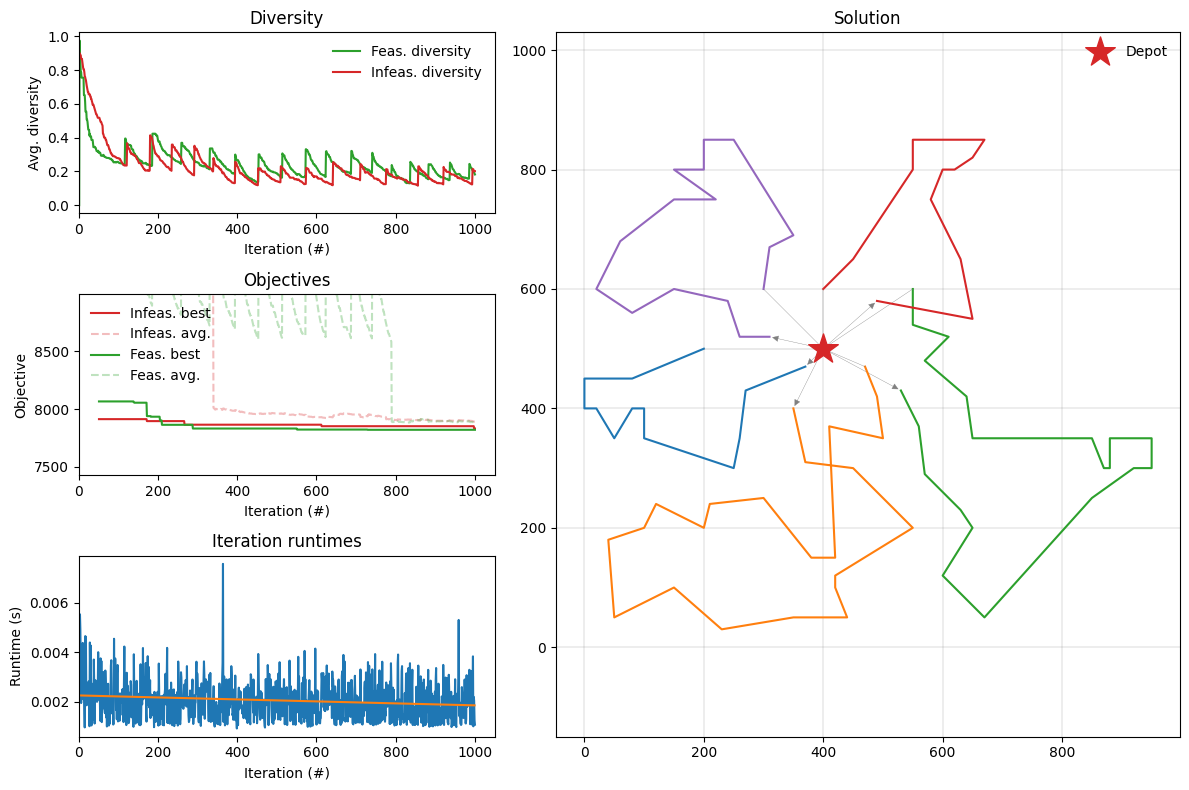

In [21]:
fig = plt.figure(figsize=(12, 8))

plot_result(res, INSTANCE, fig=fig)
plt.tight_layout()

The top-left figure shows the average diversity of the feasible and infeasible populations.
The periodic spikes are due to survivor selection: when the population grows too large, bad solutions are purged.
It is clear from this figure that periodic survivor selection improves diversity.
The middle-left figure shows the best and average objectives of both sub-populations, which improve over time as the search progresses.
The bottom-left figure shows average iteration runtimes (in seconds).
Finally, the figure on the right plots the best observed solution.

## Conclusion

In this notebook we have used some of the different components in PyVRP to implement our own `solve` function.
Along the way we learned about how PyVRP works internally.

The components we saw in this notebook can also be used to create different search algorithms altogether.
For example, our `LocalSearch` search method could be used to quickly implement an iterated local search scheme.
This modularity allows for a lot of reuse of the PyVRP package.